# Multi-Head Attention

Multi-Head Attention is an important part of all Transformer-based models.
This tutorial will show how to write it and how to then optimize it.

Let's start with an overview on BERT model architecture, where the main building block is Transfomrer Encoder, which in turn has the main block Multi-Head Attention (MHA)

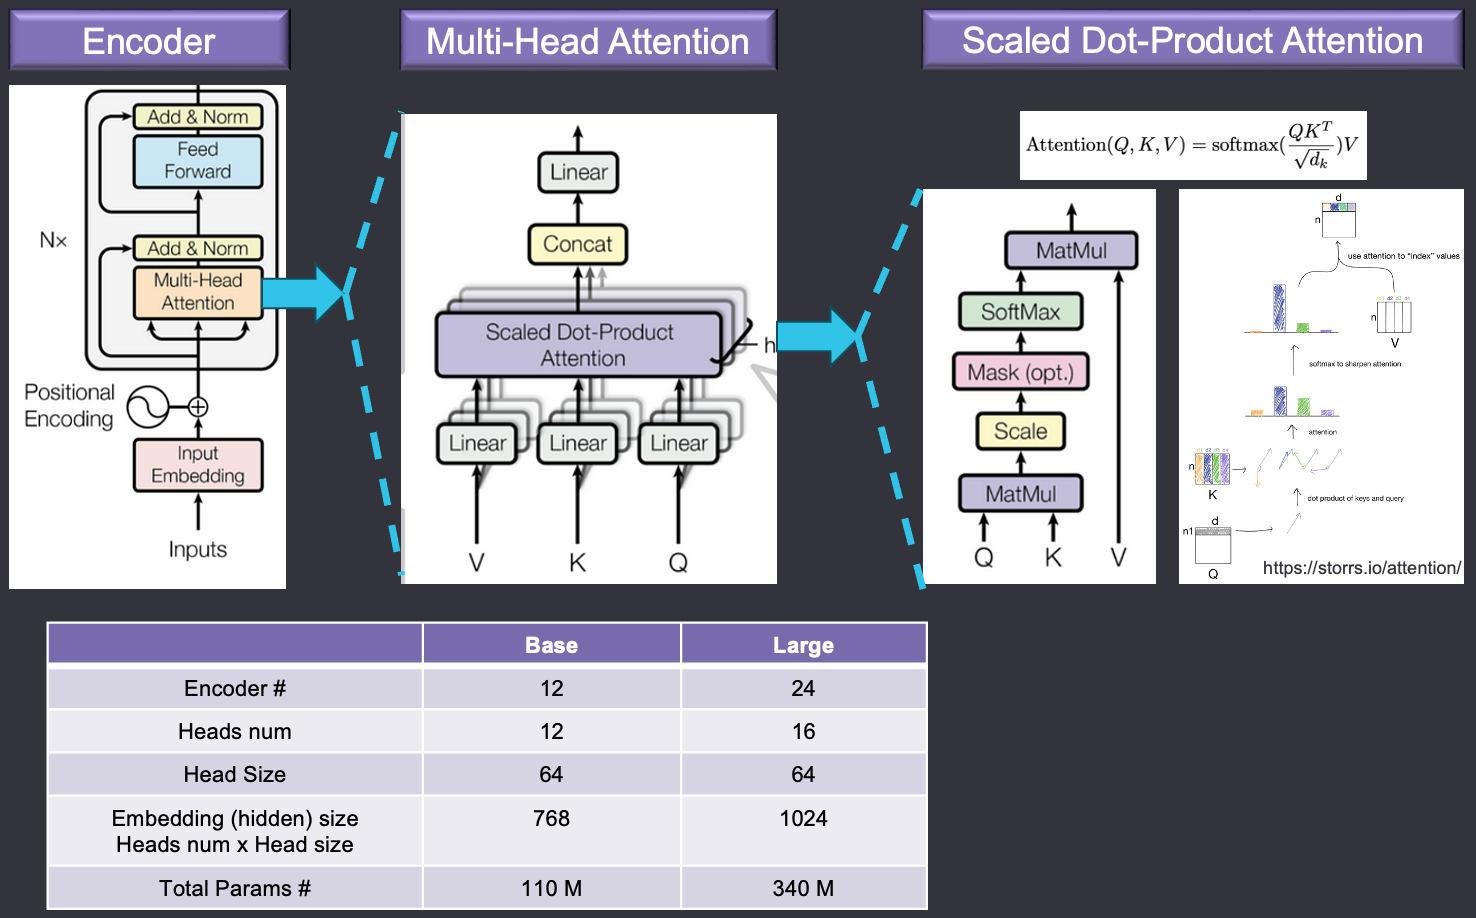

In [1]:
# BERT model architecture and size
from IPython.display import Image
Image(filename='bert_arch_table.png', width=400)
# add length of seq x number of heads = 64 x 16 = 1024 in the table

## Import libraries 

In [2]:
import time
import torch
import ttnn

torch.manual_seed(0)

device_id = 0
device = ttnn.open(device_id)
from ttnn import transformer

                  Metal | INFO     | Initializing device 0
                 Device | INFO     | Opening user mode device driver
2024-01-12 02:39:29.514 | INFO     | SiliconDriver   - Detected 1 PCI device : {0}
2024-01-12 02:39:29.529 | INFO     | SiliconDriver   - Using 1 Hugepages/NumHostMemChannels for TTDevice (logical_device_id: 0 pci_interface_id: 0 device_id: 0xfaca revision: 0)
2024-01-12 02:39:29.603 | INFO     | SiliconDriver   - Disable PCIE DMA
                  Metal | INFO     | AI CLK for device 0 is:   1202 MHz


## Enable program cache

In [3]:
ttnn.enable_program_cache()

                     Op | INFO     | Program Cache: enabled.


### MHA overview: Tensor processing and shaping
- First step is linear op (3x) between the input embeddings and each of the Q,K,V model weights.
- Second step, splitting the Q, K, V along # of heads.
- Third, running the attention score block.
- Fourth step is concatenating the per head tensors into a merged one. 

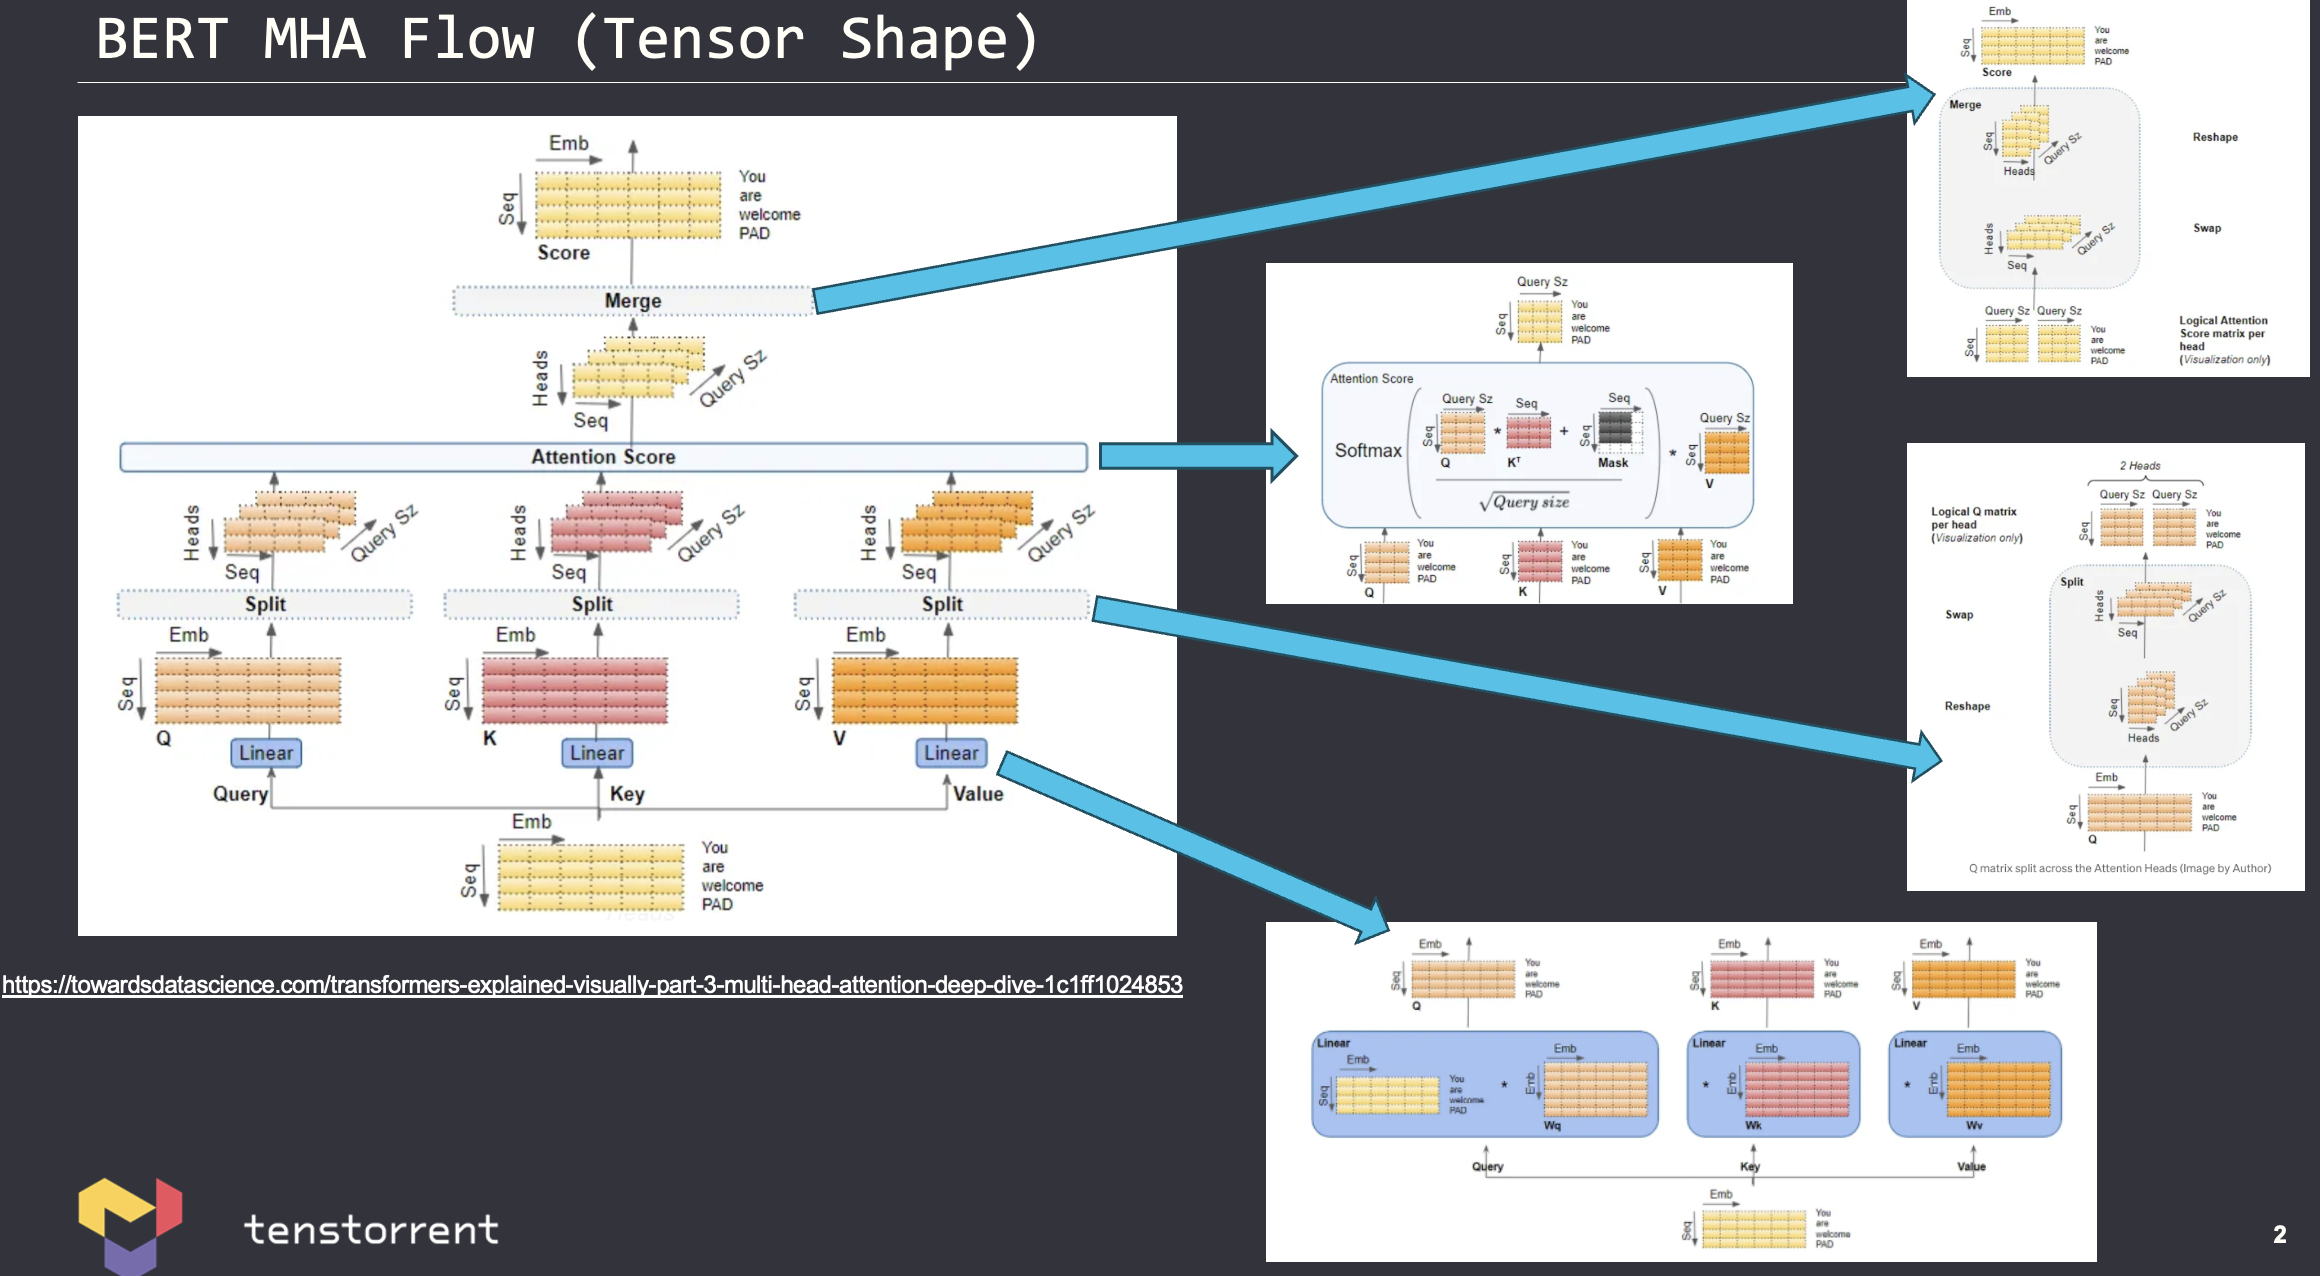

In [4]:
# MHA overview: Tensor processing and shaping
Image(filename='bert_tensor_shape.png', width=800)

### MHA OPs flow in TT-NN

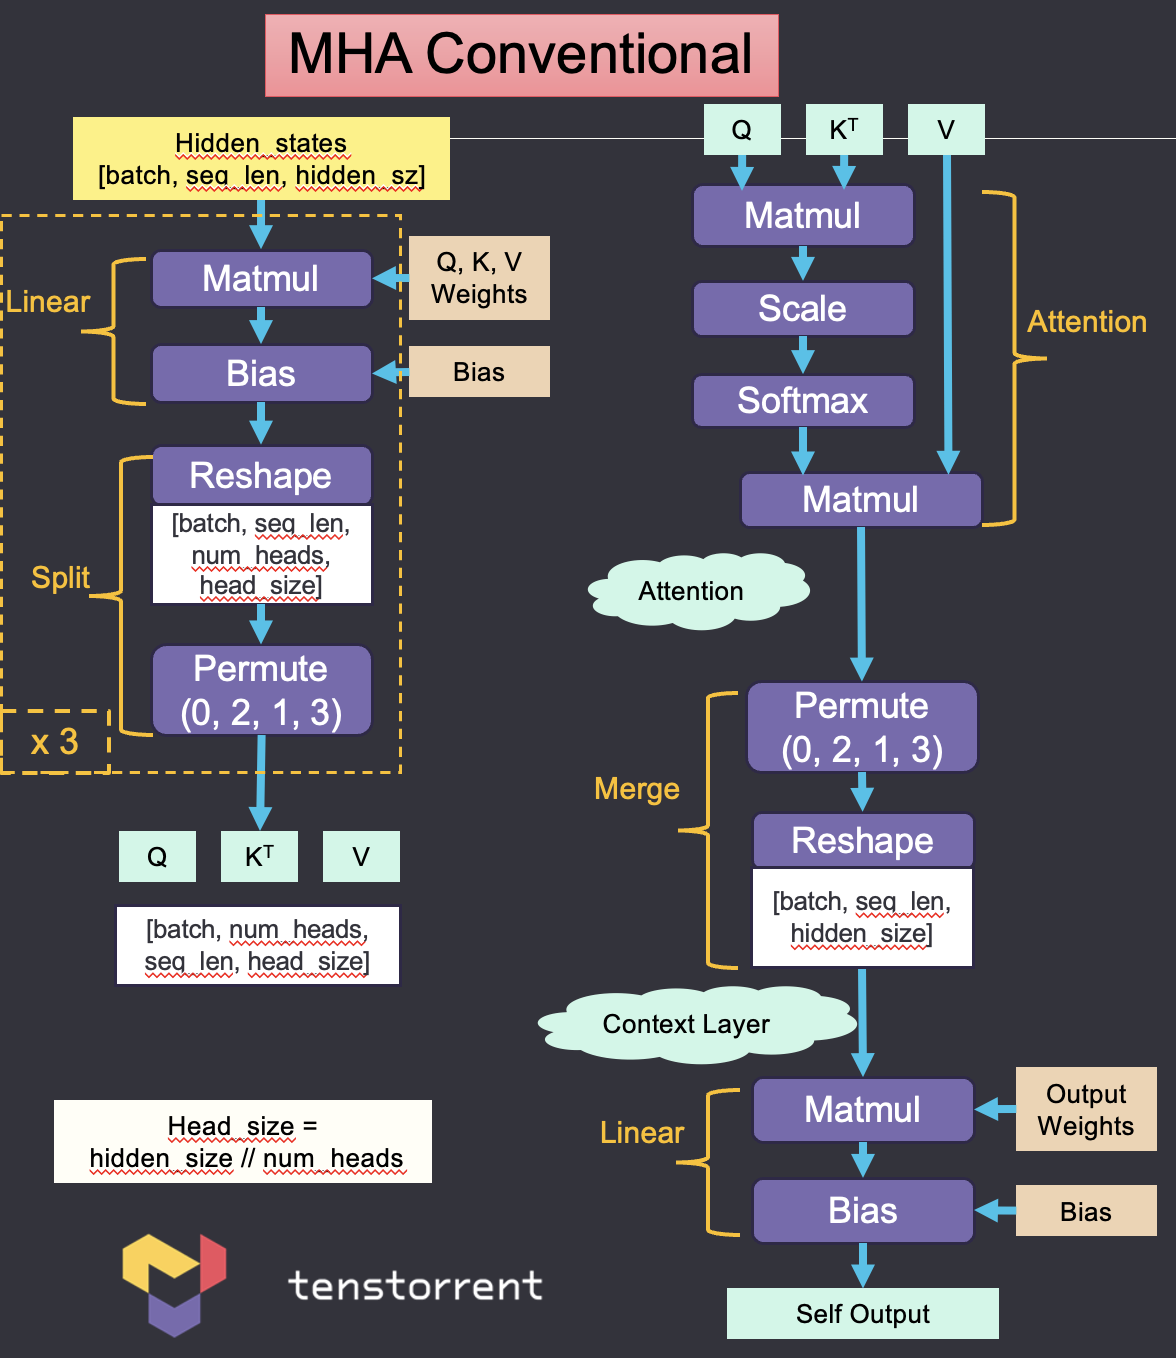

In [5]:
Image(filename='bert_ops_conventional.png', width=400)

## Write Multi-Head Attention using ttnn

Multi-head can be implemented in `torch` using just 6 operations:
1. `torch.matmul`
2. `torch.add` (bias)
3. `torch.reshape`
4. `torch.permute`
5. `torch.mul` (scale)
6. `torch.softmax`

`ttnn` provides the exact same APIs to do that and therefore multi-head attention can be implemented as shown below:

In [6]:
def multi_head_attention(
    hidden_states,
    query_weight,
    query_bias,
    key_weight,
    key_bias,
    value_weight,
    value_bias,
    output_weight,
    output_bias,
    *,
    num_heads,
):
    batch_size, sequence_size, hidden_size = hidden_states.shape
    head_size = hidden_size // num_heads

    query = hidden_states @ query_weight
    query = query + query_bias
    query = ttnn.reshape(query, (batch_size, sequence_size, num_heads, head_size))
    query = ttnn.permute(query, (0, 2, 1, 3))

    key = hidden_states @ key_weight
    key = key + key_bias
    key = ttnn.reshape(key, (batch_size, sequence_size, num_heads, head_size))
    key = ttnn.permute(key, (0, 2, 3, 1))

    value = hidden_states @ value_weight
    value = value + value_bias
    value = ttnn.reshape(value, (batch_size, sequence_size, num_heads, head_size))
    value = ttnn.permute(value, (0, 2, 1, 3))

    attention_scores = query @ key
    attention_scores = attention_scores * (1 / (head_size**0.5))
    attention_probs = ttnn.softmax(attention_scores, dim=-1)

    context_layer = attention_probs @ value
    context_layer = ttnn.permute(context_layer, (0, 2, 1, 3))
    context_layer = ttnn.reshape(context_layer, (batch_size, sequence_size, hidden_size))

    self_output = context_layer @ output_weight
    self_output = self_output + output_bias

    return self_output

## Configuration

In [7]:
batch_size = 8
sequence_size = 384
num_heads = 16
head_size = 64
hidden_size = num_heads * head_size

## Initialize activations and weights using torch

In [8]:
torch_hidden_states = torch.randn((batch_size, sequence_size, hidden_size), dtype=torch.bfloat16)
torch_query_weight = torch.randn((hidden_size, hidden_size), dtype=torch.bfloat16)
torch_query_bias = torch.randn((hidden_size,), dtype=torch.bfloat16)
torch_key_weight = torch.randn((hidden_size, hidden_size), dtype=torch.bfloat16)
torch_key_bias = torch.randn((hidden_size,), dtype=torch.bfloat16)
torch_value_weight = torch.randn((hidden_size, hidden_size), dtype=torch.bfloat16)
torch_value_bias = torch.randn((hidden_size,), dtype=torch.bfloat16)
torch_output_weight = torch.randn((hidden_size, hidden_size), dtype=torch.bfloat16)
torch_output_bias = torch.randn((hidden_size,), dtype=torch.bfloat16)

## Convert activations and weights to ttnn

In [9]:
hidden_states = ttnn.from_torch(torch_hidden_states)
query_weight = ttnn.from_torch(torch_query_weight)
query_bias = ttnn.from_torch(torch_query_bias)
key_weight = ttnn.from_torch(torch_key_weight)
key_bias = ttnn.from_torch(torch_key_bias)
value_weight = ttnn.from_torch(torch_value_weight)
value_bias = ttnn.from_torch(torch_value_bias)
output_weight = ttnn.from_torch(torch_output_weight)
output_bias = ttnn.from_torch(torch_output_bias)

                     Op | INFO     | Operation ttnn.from_torch                                                                                      finished in         1945163 nanoseconds
                     Op | INFO     | Operation ttnn.from_torch                                                                                      finished in          147807 nanoseconds
                     Op | INFO     | Operation ttnn.from_torch                                                                                      finished in           99224 nanoseconds
                     Op | INFO     | Operation ttnn.from_torch                                                                                      finished in           79747 nanoseconds
                     Op | INFO     | Operation ttnn.from_torch                                                                                      finished in           75716 nanoseconds
                     Op | INFO     | Operation ttnn.from_tor

## Move activations and weights to device

In [10]:
hidden_states = ttnn.to_device(hidden_states, device)
query_weight = ttnn.to_device(query_weight, device)
query_bias = ttnn.to_device(query_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)
key_weight = ttnn.to_device(key_weight, device)
key_bias = ttnn.to_device(key_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)
value_weight = ttnn.to_device(value_weight, device)
value_bias = ttnn.to_device(value_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)
output_weight = ttnn.to_device(output_weight, device)
output_bias = ttnn.to_device(output_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)

AttributeError: 'Tensor' object has no attribute '_tensor'

In [ ]:
hidden_states = ttnn.to_device(hidden_states, device)
query_weight = ttnn.to_device(query_weight, device)
query_bias = ttnn.to_device(query_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)
key_weight = ttnn.to_device(key_weight, device)
key_bias = ttnn.to_device(key_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)
value_weight = ttnn.to_device(value_weight, device)
value_bias = ttnn.to_device(value_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)
output_weight = ttnn.to_device(output_weight, device)
output_bias = ttnn.to_device(output_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)

## Run the first iteration of Multi-Head Attention

In [ ]:
start = time.time()
multi_head_attention(
    hidden_states,
    query_weight,
    query_bias,
    key_weight,
    key_bias,
    value_weight,
    value_bias,
    output_weight,
    output_bias,
    num_heads=num_heads,
)
end = time.time()
duration = end - start

In [ ]:
print(f"Multi-head attention ran in {duration} seconds for the first iteration")

## Run a subsequent iteration of Multi-Head Attention

In [ ]:
start = time.time()
output = multi_head_attention(
    hidden_states,
    query_weight,
    query_bias,
    key_weight,
    key_bias,
    value_weight,
    value_bias,
    output_weight,
    output_bias,
    num_heads=num_heads,
)
end = time.time()
duration = end - start

In [ ]:
print(f"Multi-head attention ran in {duration} seconds for the subsequent iteration because of the program cache")

## Write optimized version of Multi-Head Attention

Optimized version of the multi-head attention can be written by:
- Tilizing all of the tensors ahead of time
- Using more performant matmuls that fuse bias and specify the number of cores they execute on (The next 2 schematics are explaining the fused ops mapping to the conventional flow)
- Putting every tensor into L1
- Using bfloat8_b data_type
- Using custom `transformer` operations instead of `ttnn.permute` and `ttnn.reshape`

`ttnn.deallocate` calls are needed because otherwise, the cores on the device will run out of the L1 memory

In [ ]:
Image(filename='bert_ops_optim_qkv_fuse.png', width=400)

In [ ]:
Image(filename='bert_ops_optim_attention.png', width=400)

In [ ]:
def optimized_multi_head_attention(
    hidden_states,
    fused_qkv_weight,
    fused_qkv_bias,
    self_output_weight,
    self_output_bias,
    *,
    num_heads,
    num_cores_x=12,
):
    batch_size, _, hidden_size = hidden_states.shape
    head_size = hidden_size // num_heads
    
    hidden_states = ttnn.to_layout(hidden_states, ttnn.TILE_LAYOUT)

    fused_qkv_output = ttnn.linear(
        hidden_states,
        fused_qkv_weight,
        bias=fused_qkv_bias,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        dtype=ttnn.bfloat8_b,
        core_grid=(batch_size, num_cores_x),
    )

    (
        query,
        key,
        value,
    ) = ttnn.transformer.split_query_key_value_and_split_heads(
        fused_qkv_output,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        num_heads=num_heads,
    )
    ttnn.deallocate(fused_qkv_output)

    attention_scores = ttnn.matmul(
        query,
        key,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        dtype=ttnn.bfloat16,
        core_grid=(batch_size, num_cores_x),
    )
    ttnn.deallocate(query)
    ttnn.deallocate(key)

    attention_probs = ttnn.transformer.attention_softmax(attention_scores, attention_mask=None, head_size=head_size)

    context_layer = ttnn.matmul(
        attention_probs,
        value,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        dtype=ttnn.bfloat8_b,
        core_grid=(batch_size, num_cores_x),
    )
    ttnn.deallocate(attention_probs)

    context_layer = ttnn.transformer.concatenate_heads(
        context_layer,
        memory_config=ttnn.L1_MEMORY_CONFIG,
    )

    self_output = ttnn.linear(
        context_layer,
        self_output_weight,
        bias=self_output_bias,
        memory_config=ttnn.L1_MEMORY_CONFIG,
        dtype=ttnn.bfloat16,
        core_grid=(batch_size, num_cores_x),
    )
    ttnn.deallocate(context_layer)

    return self_output

## Pre-process the parameters of the optimized model

1. Fuse QKV weights and biases
2. Reshape and tilize for the optimized operations using preprocess_linear_weight and preprocess_linear_bias
3. Move to device

## Fuse QKV weights and biases 
- One optimization step is replacing the convnetional 3 Linear OPs (of multiplying the input embeddings by each of Q,K,V weights) by one large fused Linear OP (multiplying the input embeddings by the fused QKV weight tensor)
- For the following prpeocessing functions, the main step is from_torch(), followed by tile_layout processing, to eliminate the redundant intemrediate tiling steps between OPs.

In [ ]:
from ttnn.model_preprocessing import (
    preprocess_linear_bias,
    preprocess_linear_weight,
)

torch_qkv_weight = torch.cat([torch_query_weight, torch_key_weight, torch_value_weight], dim=-1)
torch_qkv_bias = torch.cat([torch_query_bias, torch_key_bias, torch_value_bias], dim=-1)

qkv_weight = preprocess_linear_weight(torch_qkv_weight.T, dtype=ttnn.bfloat16)
qkv_bias = preprocess_linear_bias(torch_qkv_bias, dtype=ttnn.bfloat16)
output_weight = preprocess_linear_weight(torch_output_weight.T, dtype=ttnn.bfloat16)
output_bias = preprocess_linear_bias(torch_output_bias, dtype=ttnn.bfloat16)

qkv_weight = ttnn.to_device(qkv_weight, device)
qkv_bias = ttnn.to_device(qkv_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)
output_weight = ttnn.to_device(output_weight, device)
output_bias = ttnn.to_device(output_bias, device, memory_config=ttnn.L1_MEMORY_CONFIG)

## Run the first iteration of the optimized Multi-Head Attention

In [ ]:
start = time.time()
hidden_states = ttnn.to_layout(hidden_states, ttnn.TILE_LAYOUT)
optimized_output = optimized_multi_head_attention(
    hidden_states,
    qkv_weight,
    qkv_bias,
    output_weight,
    output_bias,
    num_heads=num_heads,
)
end = time.time()
duration = end - start

In [ ]:
print(f"Optimized multi-head attention ran in {duration} seconds for the first iteration")

## Run a subsequent iteration of the optimized Multi-Head Attention

In [ ]:
start = time.time()
optimized_output = optimized_multi_head_attention(
    hidden_states,
    qkv_weight,
    qkv_bias,
    output_weight,
    output_bias,
    num_heads=num_heads,
)
end = time.time()
duration = end - start

In [ ]:
print(f"Optimized multi-head attention ran in {duration} seconds for the subsequent iteration because of the program cache")

## Check that the output of the optimized version matches the output of the original implementation

In [ ]:
output = ttnn.to_layout(output, ttnn.ROW_MAJOR_LAYOUT)
output = ttnn.from_device(output)
torch_output = ttnn.to_torch(output)

optimized_output = ttnn.to_layout(optimized_output, ttnn.ROW_MAJOR_LAYOUT)
optimized_output = ttnn.from_device(optimized_output)
torch_optimized_output = ttnn.to_torch(optimized_output)

assert torch.allclose(torch_output, torch_optimized_output)

## Close the device

In [ ]:
ttnn.close(device)